In [1]:
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import pickle
import mygene
import seaborn as sns
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
markers = pd.read_excel('../benchmarking_data/41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

In [3]:
tdata = pd.read_table("../benchmarking_data/GSE133541_ICELL8_human_exp_mat.tsv.gz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("../benchmarking_data/GSE133541_ICELL8_human_metada.tsv.gz", compression='gzip')

In [4]:
cells = metadata.query('nTReads > 10000 & nUnmappedReads / nTReads < 0.35').index
adata = adata[cells]
sc.pp.filter_genes(adata, min_cells=5)



Trying to set attribute `.var` of view, copying.


In [4]:
hca_annot = pd.read_table("../benchmarking_data/HCA_annotations.txt")

cells = [x for x in hca_annot.query('batch == "ICELL8"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)

Trying to set attribute `.obs` of view, copying.


In [5]:
mg = mygene.MyGeneInfo()

In [6]:

ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-25680...done.
Finished.


/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


21 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000124334', 2), ('ENSG00000167393', 2), ('E
128 input query terms found no hit:
	['ENSG00000154537', 'ENSG00000163009', 'ENSG00000167945', 'ENSG00000168078', 'ENSG00000170165', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [7]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

In [8]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

Trying to set attribute `.obs` of view, copying.
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:1171: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


In [10]:
adata

AnnData object with n_obs × n_vars = 1829 × 9081 
    obs: 'nnet2', 'percent_mito', 'n_counts', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
sc.tl.umap(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:03)
computing UMAP
    finished (0:00:06)


In [12]:
sc.tl.diffmap(adata, n_comps=20)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=30,use_rep='X_diffmap')

computing Diffusion Maps using n_comps=20(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.95220613 0.94939727 0.9169704  0.9106866  0.9049004
     0.8972811  0.8879868  0.88690585 0.86054957 0.85366523 0.8299942
     0.80153286 0.79182994 0.7882495  0.77651197 0.7705044  0.76373607
     0.75445056 0.72999406]
    finished (0:00:00)
computing neighbors
    finished (0:00:00)


In [10]:
sc.tl.leiden(adata)

running Leiden clustering
    finished (0:00:00)


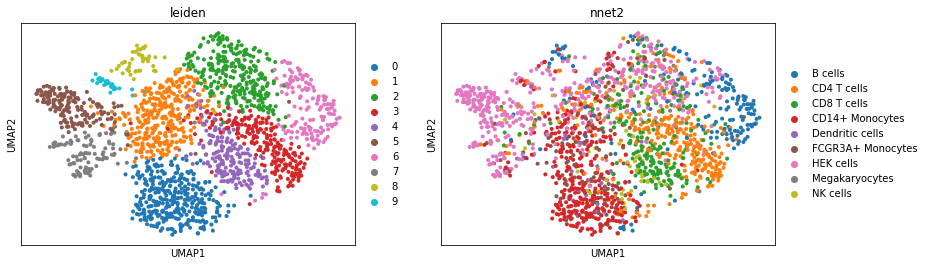

In [11]:
sc.pl.umap(adata,color=['leiden','nnet2'])

In [14]:
adata.write('state_adata/adata_iCELL8_denoised.h5ad')

In [2]:
adata=sc.read('state_adata/adata_iCELL8_denoised.h5ad')

In [12]:
sc.settings.verbosity=2
schist.inference.nested_model(adata, equilibrate=False,deg_corr=True,use_weights=False, steps_anneal=3,n_init=3)

minimizing the nested Stochastic Block Model
    done (0:06:07)
    calculating cell affinity to groups
    finished (0:06:13)


In [26]:
schist.io.write(adata, prefix='state_adata/iCELL8_minimize_denoised_weighted')

In [27]:
adata=schist.io.read('state_adata/iCELL8_minimize_denoised_weighted')

<BarContainer object of 10 artists>

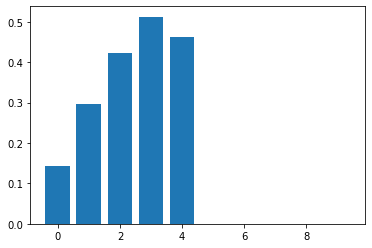

In [17]:
modularity=[x for x in adata.uns['nsbm']['stats']['modularity']]
levels=[x for x in range(len(modularity))]
bar(levels,modularity)

<ipython-input-16-a9616e1fe12d>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0
1
4
8
9


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


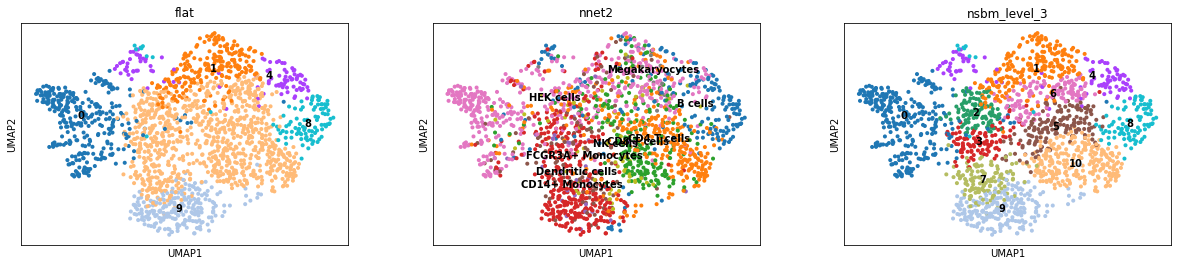

[0.02287581699346405, 0.01834862385321101, 0.0990990990990991, 0.0707070707070707, 0.039603960396039604, 0.07317073170731707, 0.08870967741935484, 0.07751937984496124, 0.030612244897959183, 0.017167381974248927, 0.06072874493927125]


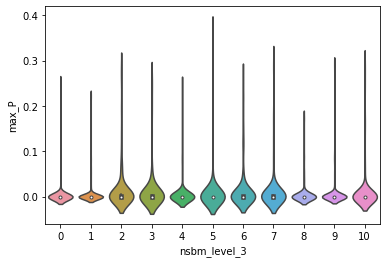

In [16]:
level=str(3)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
#adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
#        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
#    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

###### minimize weighted

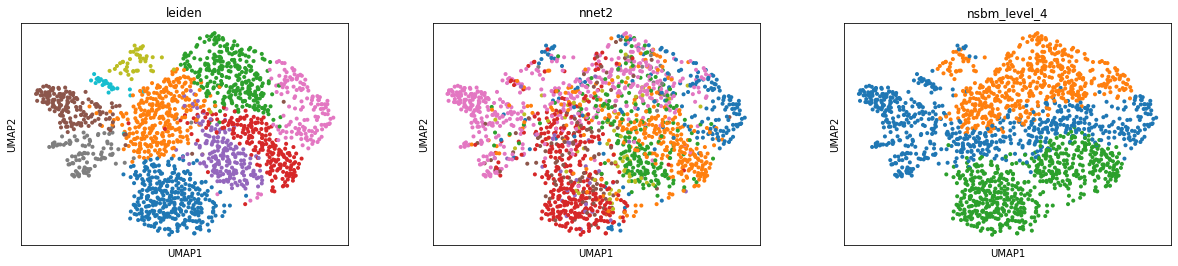

In [18]:
sc.pl.umap(adata, color=["leiden",'nnet2','nsbm_level_4'], legend_loc='on_data')

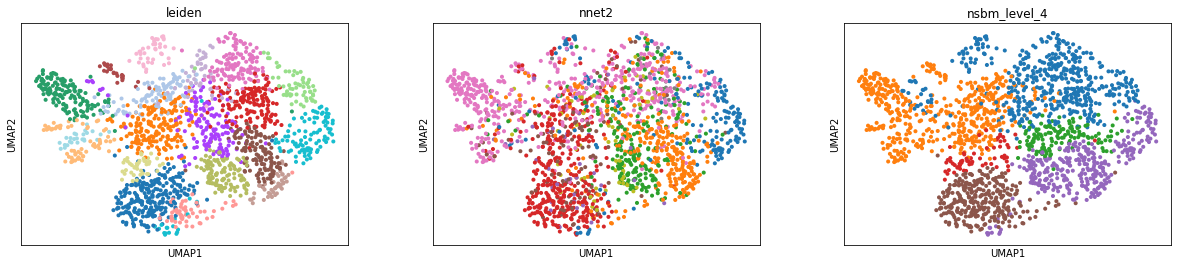

In [22]:
sc.pl.umap(adata, color=["leiden",'nnet2','nsbm_level_4'], legend_loc='on_data')

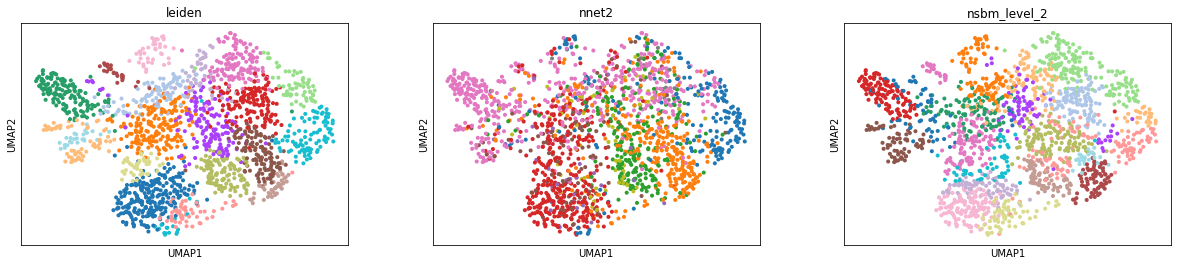

In [31]:
sc.pl.umap(adata, color=["leiden",'nnet2','nsbm_level_2'], legend_loc='on_data')

##### entropia minimize weighted

In [23]:
#minimize flat denoised
sum(adata.uns['nsbm']['stats']['level_entropy'])

76989.25239646385

In [20]:
# minimize weigthed
sum(adata.uns['nsbm']['stats']['level_entropy'])

130691.40827801803

In [28]:
#minimize weighted denoised
sum(adata.uns['nsbm']['stats']['level_entropy'])

69604.89057591818

##### entropia equilibrate flat

In [5]:
sum(adata.uns['nsbm']['stats']['level_entropy'])

129542.92238796227

# PAGA


paga leiden
running PAGA
    finished (0:00:00)


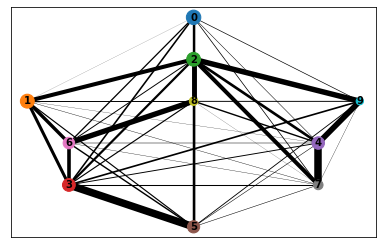

paga nsbm
running PAGA
    finished (0:00:00)


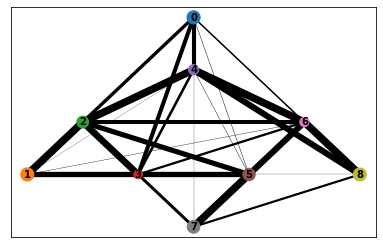

In [20]:
print('paga leiden')
sc.tl.paga(adata,groups='leiden')
sc.pl.paga(adata, color=['leiden'],layout='eq_tree')
print('paga nsbm')
sc.tl.paga(adata,groups='nsbm_level_3')
sc.pl.paga(adata, color=['nsbm_level_3'],layout='eq_tree')

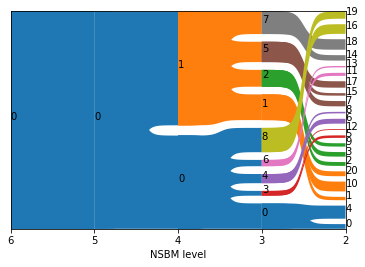

In [27]:
scnsbm.pl.alluvial(adata,level_end=6, level_start=2)

In [24]:
M=adata.uns['nsbm']['cell_affinity']['3']
adata.obs['max_u'] = 1 - np.max(M, axis=1) 

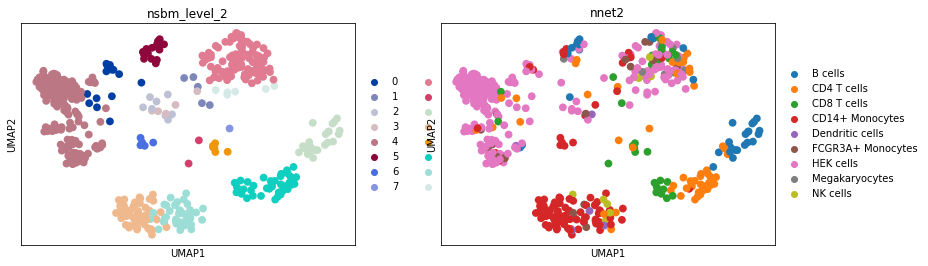

In [25]:
sc.pl.umap(adata[adata.obs.max_u < 1e-100], color=['nsbm_level_2','nnet2'])

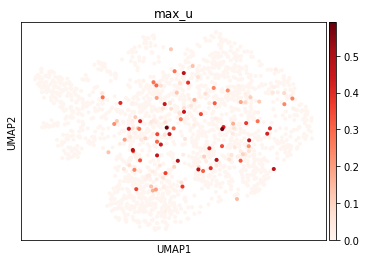

In [26]:
sc.pl.umap(adata, color ='max_u',color_map='Reds')